# Adding Histogram loss to Style Transfer

In this notebook, I define and add a histogram loss and gradient, as per [Stable and Controllable Neural Texture Synthesis and Style Transfer Using Histogram Losses](https://arxiv.org/abs/1701.08893). 

However, this method fails to replicate the results shown in the paper, primarily because the calculated gradient is scalar, and fails to capture pixel specific details. 


In [1]:
% matplotlib inline

import numpy as np 

import matplotlib.pyplot as plt

import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from VGG16 import VGG16

from keras.models import Model

from keras import backend as K

from PIL import Image



Using TensorFlow backend.


In [2]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [3]:
limit_mem()

First, defining the VGG network 

Now, loading the data

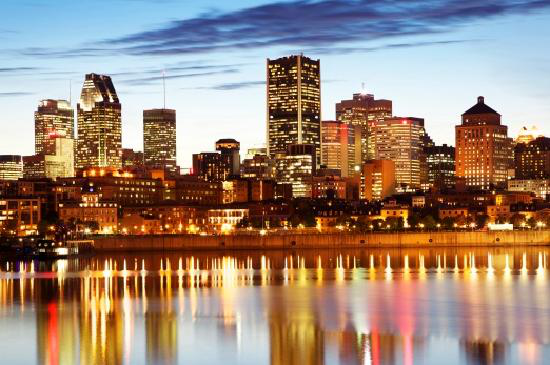

In [4]:
content = Image.open('images/inputs/content/downtown-montreal.jpg')
content

I want to mantain the size of my original size, so I need to make sure to resize my input style image appropriately. 

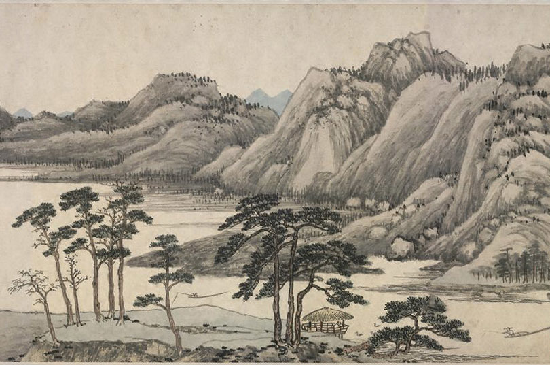

In [5]:
style = Image.open('images/inputs/style/fuchun-mountains.jpg').resize(content.size)
style

## Preprocessing the images

In [6]:
def image_preprocess(img_ar):
    '''
    Input: image as numpy array
    Output: preprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    exp_img_ar = np.expand_dims(np.array(img_ar), 0)
    proc_img_ar = (exp_img_ar - resnet_mean)[:,:,:,::-1]
    return proc_img_ar
#end

def image_postprocess(img_ar, shp):
    '''Input: preprocessed image as numpy array
       Output: postprocessed image as numpy array
    '''
    resnet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
    postpr_img_ar = np.clip(img_ar.reshape(shp)[:,:,:,::-1] + resnet_mean, 0, 255)
    return postpr_img_ar
#end

In [7]:
content_array = image_preprocess(content)

In [8]:
style_array = image_preprocess(style)

In [9]:
image_array_shape = content_array.shape

## Defining Losses

### Content Loss

In [10]:
def content_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one content layer)
    Output: content loss calculated as MSE and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        c_loss = sum([K.sum(metrics.mse(comp[0], targ[0]) * w \
                      for comp, targ, w in zip(computed, target, weight_ls))])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        c_loss = K.sum(metrics.mse(computed, target))
        _, height, width, channels = K.int_shape(computed)
    #end
    c_loss = c_loss #/ (height * width * channels)
    return c_loss

### Style loss 

#### Gram Loss

In [11]:
def gram_matrix(tens):
    features = K.batch_flatten(K.permute_dimensions(tens, (2, 0, 1))) # rows = channels, columns = flattened x, y
    gram = K.dot(features, K.transpose(features)) / tens.get_shape().num_elements() #correlate each pair of channels
    return gram
#end

def style_loss(computed, target, weight_ls=None):
    '''
    Input: computed and target tensors (or lists of tensors for more than one style layer)
    Output: content loss calculated as MSE of the Gram matrices and scaled by the tensor(s) dimension
    '''
    if isinstance(computed, list):
        if not weight_ls:
            weight_ls = [1.0 for layer in computed]
        #end
        s_loss = sum([K.sum(metrics.mse(gram_matrix(comp[0]), gram_matrix(targ[0]))) * w \
                      for comp, targ, w in zip(computed, target, weight_ls)])
        _, height, width, channels = map(lambda i: i, K.int_shape(computed[0]))
    else:
        s_loss = K.sum(metrics.mse(gram_matrix(computed), gram_matrix(target)))
        _, height, width, channels = K.int_shape(computed)
    #end
    s_loss = s_loss #/ (height * width * channels)
    return s_loss

#### Histogram Loss

In [12]:
def hist_match(source, template):
    shape = K.tf.shape(source)
    source = K.flatten(source)
    template = K.flatten(template)
    # get the set of unique pixel values and their corresponding indices and
    # counts

    hist_bins = 255

    # Defining the 'x_axis' of the histogram

    max_value = K.tf.reduce_max([K.tf.reduce_max(source), K.tf.reduce_max(template)])
    min_value = K.tf.reduce_min([K.tf.reduce_min(source), K.tf.reduce_min(template)])

    hist_delta = (max_value - min_value)/hist_bins

    # Getting the x-axis for each value
    hist_range = K.tf.range(min_value, max_value, hist_delta)
    # I don't want the bin values; instead, I want the average value of each bin, which is 
    # lower_value + hist_delta/2
    hist_range = K.tf.add(hist_range, K.tf.divide(hist_delta, 2))

    # Now, making fixed width histograms on this hist_axis 

    s_hist = K.tf.histogram_fixed_width(source, 
                                        [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )


    t_hist = K.tf.histogram_fixed_width(template, 
                                         [min_value, max_value],
                                         nbins = hist_bins, 
                                        dtype = K.tf.int64
                                        )

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = K.tf.cumsum(s_hist)
    s_last_element = K.tf.subtract(K.tf.size(s_quantiles), K.tf.constant(1))
    s_quantiles = K.tf.divide(s_quantiles, K.tf.gather(s_quantiles, s_last_element))

    t_quantiles = K.tf.cumsum(t_hist)
    t_last_element = K.tf.subtract(K.tf.size(t_quantiles), K.tf.constant(1))
    t_quantiles = K.tf.divide(t_quantiles, K.tf.gather(t_quantiles, t_last_element))


    nearest_indices = K.tf.map_fn(lambda x: K.tf.argmin(K.tf.abs(K.tf.subtract(t_quantiles, x))), 
                                  s_quantiles, dtype = K.tf.int64)

    # Finding the correct s-histogram bin for every element in source
    s_bin_index = K.tf.to_int64(K.tf.divide(source, hist_delta))



    ## In the case where an activation function of 0-1 is used, then there might be some index exception errors. 
    ## This is to deal with those
    s_bin_index = K.tf.clip_by_value(s_bin_index, 0, 254)

    # Matching it to the correct t-histogram bin, and then making it the correct shape again
    matched_to_t = K.tf.gather(hist_range, K.tf.gather(nearest_indices, s_bin_index))
    return K.tf.reshape(matched_to_t, shape)

In [13]:
def hist_loss(calculated, target):
    if isinstance(calculated, list):
        histogram = ([hist_match(calc, targ)
                   for calc,  targ in zip(calculated, target)])
        print ("histogram is " + str(histogram))
        loss = sum([K.sum(metrics.mse(calc,hist))
                   for calc,  hist in zip(calculated, histogram)])
    else: 
        histogram = hist_match(calculated, target)
        loss = K.sum(metrics.mse(calculated,histogram))
    return loss

In [34]:
def total_loss(style_layer_ls, style_targ_ls, style_wgt_ls, content_layer, content_targ, style2content_ratio, 
              hist_layer_ls, hist_targ_ls, hist_ratio):
    s_loss = style_loss(style_layer_ls, style_targ_ls, style_wgt_ls)
    h_loss = hist_loss(hist_layer_ls, hist_targ_ls) / hist_ratio
    c_loss = content_loss(content_layer, content_targ)
    loss = s_loss + h_loss + c_loss / style2content_ratio
    return loss
#end

## Getting the targets

In [15]:
def get_content_targets(style_transfer_model, content_ar):
    '''
    Input: style transfer model and numpy array of the content image
    Output: the output of the model at the content layer and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    content_layer = layer_output_dc['block4_conv2'] #change it to another layer of choice if necessary
    content_model = Model(style_transfer_model.input, content_layer)
    content_targ = K.variable(content_model.predict(content_ar))
    return content_layer, content_targ
#end 

In [16]:
def get_style_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the style layer(s) and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    style_layer_ls = [layer_output_dc['block{}_conv2'.format(o)] for o in range(1,6)] #change it different layers if necessary
    style_model = Model(style_transfer_model.input, style_layer_ls)
    style_targ_ls = [K.variable(o) for o in style_model.predict(style_ar)]
    return style_layer_ls, style_targ_ls
#end 

In [17]:
def get_hist_targets(style_transfer_model, style_ar):
    '''Input: style transfer model and numpy array of the style image
       Output: the output of the model at the histogram layers, and its respective target
    '''
    layer_output_dc = {l.name: l.get_output_at(0) for l in style_transfer_model.layers}
    hist_layer_ls = [layer_output_dc['block{}_conv1'.format(b)] for b in [1]] # ,4 
    hist_model = Model(style_transfer_model.input, hist_layer_ls)
    hist_targ_ls = [K.variable(o) for o in hist_model.predict(style_ar)]
    return hist_layer_ls, hist_targ_ls

## Defining the evaluator

In [18]:
class Evaluator(object):
    '''
    Initialization: function and shape of the image array
    Returns the loss and the gradients as computed with
       respect to the image that is fed to the CNN
    '''
    def __init__(self, f, shp):
        self.f = f
        self.shp = shp
        return
    #end        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    #end
    def grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    #end    
#end

## A handy method to 'train' our image

In [19]:
def apply_transfer(eval_obj, n_iter, img, shp, path='./', pref='', save=True, verbose=True):
    '''
    Input: evaluator, number of iterations, input image and shape
    Output: final image, list of losses and info dictionary of optimization procedure
    '''
    info_dc = dict()
    loss_ls = list()
    for it in range(n_iter):
        img, min_val, iter_dc = fmin_l_bfgs_b(eval_obj.loss, img.flatten(),
                                              fprime=eval_obj.grads, maxfun=20, iprint = 1)
        img = np.clip(img, -127, 127)
        info_dc['iteration_'+str(it+1)] = iter_dc
        loss_ls = loss_ls + [min_val]
        if verbose:
            print('Current loss value:', min_val)
        #end
        if save:
            imsave(path + pref + 'res_at_iteration_' + str(it+1) + '.png', image_postprocess(img.copy(), shp)[0])
        #end
    #end
    return img, loss_ls, info_dc
#end

We're good to start. Let's start by defining the CNN

In [20]:
transfer_model = VGG16(pooling = 'Average', include_top =False, input_shape = image_array_shape[1:])

Now, I can get the content / style layers and targets

In [21]:
content_layer, content_targ = get_content_targets(transfer_model, content_array)
style_layer_ls, style_targ_ls = get_style_targets(transfer_model, style_array)
hist_layer_ls, hist_targ_ls = get_hist_targets(transfer_model, style_array)

Setting some contants

In [35]:
iterations = 10

style_wgt_ls = [0.05,0.2,0.2,0.25,0.3]
style2content_ratio = 15.0
hist_ratio = 100

In [36]:
loss = total_loss(style_layer_ls, style_targ_ls, style_wgt_ls, content_layer, content_targ, style2content_ratio, 
              hist_layer_ls, hist_targ_ls, hist_ratio)

histogram is [<tf.Tensor 'Reshape_35:0' shape=(?, 365, 550, 64) dtype=float32>]


In [37]:
gradient = K.gradients(loss, transfer_model.input)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [38]:
transfer_fn = K.function([transfer_model.input], [loss] + gradient)

In [39]:
evaluator = Evaluator(transfer_fn, image_array_shape)

In [40]:
virgin_img = np.random.uniform(-2.5, 2.5, image_array_shape)/100

image, t_loss, info_dc = apply_transfer(evaluator, iterations, virgin_img, image_array_shape, path='images/combined_test/6-hist/')

Current loss value: 884136.25
Current loss value: 623167.0625
Current loss value: 583153.75
Current loss value: 518454.6875
Current loss value: 510933.15625
Current loss value: 477756.1875
Current loss value: 452471.875
Current loss value: 442966.4375
Current loss value: 441961.15625
Current loss value: 441945.53125


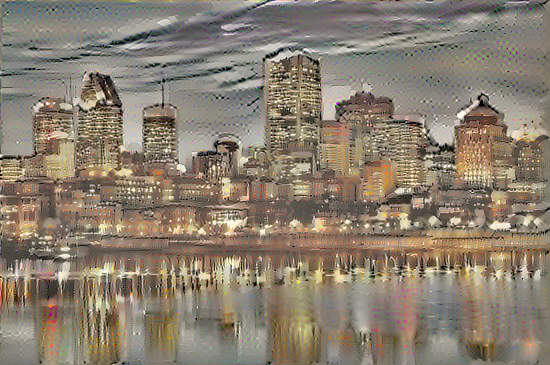

In [41]:
Image.open('images/combined_test/6-hist/res_at_iteration_10.png')

## Starting with the content image (as per Novak and Nikulin) 

In [42]:
start_img = np.copy(content_array)

image, t_loss, info_dc = apply_transfer(evaluator, iterations, start_img, image_array_shape, path='images/combined_test/7-hist-content-start/')

Current loss value: 453548.625
Current loss value: 421877.625
Current loss value: 365317.75
Current loss value: 333596.875
Current loss value: 322375.09375
Current loss value: 310020.4375
Current loss value: 306814.125
Current loss value: 306620.0
Current loss value: 306537.75
Current loss value: 306537.9375


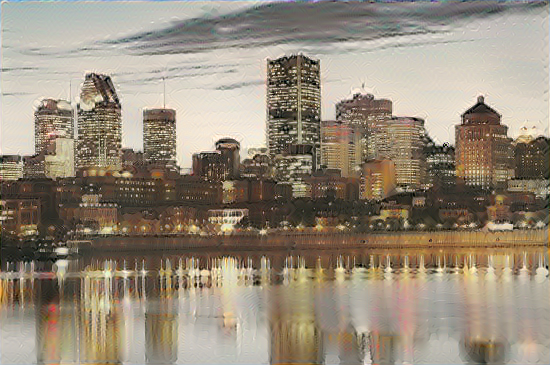

In [43]:
Image.open('images/combined_test/7-hist-content-start/res_at_iteration_10.png')

This *definitely* improves the smoothness of the image (compare to with co-occurences or without histograms at all). 

Success!